In [6]:
import torch
import torch.nn as nn
#import matplotlib as mp
import matplotlib.pyplot as mp
import numpy as np

torch.Size([1000])
torch.Size([1000])


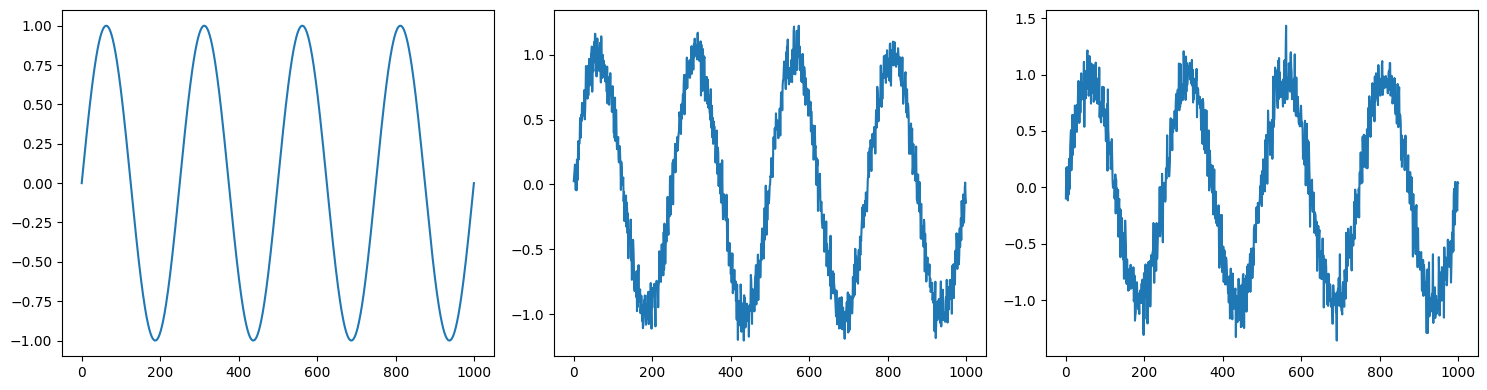

In [16]:
data_len=1000
origin_data=torch.sin(torch.linspace(0,8*np.pi,data_len))
print(origin_data.size())

def add_noise(data,noise):
    return data+torch.randn(data.size())*noise

def remove_noise(noise_data,noise):
    return noise_data-torch.randn(noise_data.size())*noise


noise=0.1
noise_data=add_noise(origin_data,noise)
print(noise_data.size())

denoise_data=remove_noise(noise_data,noise)

mp.figure(figsize=(15,4))
mp.subplot(1,3,1)
mp.plot(origin_data.numpy())

mp.subplot(1,3,2)
mp.plot(noise_data.numpy())

mp.subplot(1,3,3)
mp.plot(denoise_data)
mp.tight_layout()
mp.show()

원본 데이터 생성: 예시로 사인파를 사용하여 1차원 데이터를 생성했습니다. 이 데이터는 실제 응용에서는 이미지나 텍스트와 같은 복잡한 데이터가 될 수 있습니다.

잡음 추가: 원본 데이터에 잡음을 추가하여 '노이즈가 섞인 데이터'를 생성했습니다. 이 과정은 디퓨전 모델의 '노이즈 추가' 단계를 모방합니다.

잡음 제거: 노이즈가 섞인 데이터에서 잡음을 제거하여 '복원된 데이터'를 생성했습니다. 실제 디퓨전 모델에서는 이 단계가 훨씬 더 복잡하며, 딥러닝 모델을 사용하여 데이터에서 잡음을 제거합니다.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms as tf


In [58]:
class CNN(nn.Module):
    def __init__(self,input,out):
        super(CNN,self).__init__()
        self.lay1=nn.Conv2d(in_channels=input,out_channels=out,kernel_size=(2,2),stride=1, padding=2 )
        self.maxpool=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten=nn.Flatten()
        self.relu=nn.ReLU()

    def forward(self,x):
        x=self.lay1(x)
        print(x.shape)
        x=self.maxpool(x)
        print(x.shape)
        x=self.flatten(x)
        print(x.shape)
        x=self.relu(x)
        return x


sample_image = torch.randn(1, 1, 28, 28)  # [batch_size, channels, height, width]
num_epochs=1000
lr=0.001
model=CNN(input=1,out=19)

noise=0.01
criter=nn.CrossEntropyLoss()
opt=optim.SGD(model.parameters(),lr=lr)


def diffusion(data,noise):
    noise_data=data+torch.randn_like(data)*noise
    remode_noise=noise_data-torch.randn_like(noise_data)*noise
    return remode_noise

diffusion=diffusion(model(sample_image),noise)

print('=========='*10)

print(model(sample_image))
print('=========='*10)

print(diffusion)

torch.Size([1, 19, 31, 31])
torch.Size([1, 19, 15, 15])
torch.Size([1, 4275])
torch.Size([1, 19, 31, 31])
torch.Size([1, 19, 15, 15])
torch.Size([1, 4275])
tensor([[0.2553, 0.3565, 0.6519,  ..., 0.0000, 0.5582, 0.5043]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2359,  0.3552,  0.6559,  ..., -0.0111,  0.5699,  0.5108]],
       grad_fn=<SubBackward0>)


In [197]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

class CNNdeff(nn.Module):
    def __init__(self):
        super(CNNdeff,self).__init__()
        self.lay1 = nn.Conv2d(1, 64, kernel_size=(2, 2), padding=2, stride=1)
        self.lay2 = nn.Conv2d(64, 256, kernel_size=(2, 2), padding=2, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        # 계산된 텐서 크기에 맞게 입력 크기를 조정
        self.lc1 = nn.Linear(256 * 7 * 7, 16) 
        '''self.lay3=nn.Conv2d(,kernel_size=(2,2),padding=2,stride=1)
        #self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=1)
        self.flatten=nn.Flatten()
        self.relu=nn.ReLU()
        self.lay4=nn.Conv2d()
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=1)
        self.flatten=nn.Flatten()
        self.relu=nn.ReLU()'''
        self.lc1 = nn.Linear(20736, 16)
        #self.lc2=nn.Linear()
        #self.lc2=nn.Linear()
        self.gelu=nn.GELU()

    def forward(self,x):
        x=self.relu(self.lay1(x))
        print(f'1conv : {x.shape}')
        x = self.maxpool(x)
        print(x.shape)

        x=self.relu(self.lay2(x))
        print(f'2lay : {x.shape}')
        x = self.maxpool(x)
        print(x.shape)
        x=self.flatten(x)
        print(x.shape)

        x=self.lc1(x)
        print(f'lc1 : {x.shape}')
        return self.gelu(x)


transform=transforms.Compose([transforms.ToTensor(),])
train_data=datasets.FashionMNIST(root='data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST(root='data',train=False,download=True,transform=transform)

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure=mp.figure(figsize=(10,10))
cols,rows=6,5
for i in range(1,cols*rows+1):
    sample=torch.randint(len(train_data),size=(1,)).item()
    img,label=train_data[sample]
    figure.add_subplot(rows,cols,i)
    mp.title(labels_map[label])
    mp.axis('off')
    mp.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
    mp.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')

mp.show()

batch=16
num_work=8
train_loader=DataLoader(train_data,batch_size=batch,shuffle=True,num_workers=num_work)
test_loader=DataLoader(test_data,batch_size=batch,shuffle=True,num_workers=num_work)

img,label=next(iter(train_loader))
img.size()
#label.size()

device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
model=CNNdeff().to(device)
model=model.to(device)
criter=nn.CrossEntropyLoss().to(device)
opt=optim.SGD(model.parameters(),lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    avg_cost = 0
    total_batch = len(train_loader)
    model.train()
    for x, y in train_loader:
        x = x.to(device)  # 데이터를 GPU로 이동
        y = y.to(device)  # 레이블을 GPU로 이동
        output = model(x)
        loss = criter(output, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        avg_cost += loss / total_batch
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [229]:
class CNNdeff(nn.Module):
    def __init__(self):
        super(CNNdeff,self).__init__()
        self.lay1 = nn.Conv2d(1, 64, kernel_size=(2, 2), padding=2, stride=1)
        self.lay2 = nn.Conv2d(64, 256, kernel_size=(2, 2), padding=2, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        # 계산된 텐서 크기에 맞게 입력 크기를 조정
        self.lc1 = nn.Linear(256 * 7 * 7, 16) 
        '''self.lay3=nn.Conv2d(,kernel_size=(2,2),padding=2,stride=1)
        #self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=1)
        self.flatten=nn.Flatten()
        self.relu=nn.ReLU()
        self.lay4=nn.Conv2d()
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=1)
        self.flatten=nn.Flatten()
        self.relu=nn.ReLU()'''
        self.lc1 = nn.Linear(20736, 16)
        self.lc2=nn.Linear(16,10)
        #self.lc2=nn.Linear()
        self.gelu=nn.GELU()

    def forward(self,x):
        x=self.relu(self.lay1(x))
        print(f'1conv : {x.shape}')
        x = self.maxpool(x)
        print(x.shape)

        x=self.relu(self.lay2(x))
        print(f'2lay : {x.shape}')
        x = self.maxpool(x)
        print(x.shape)
        x=self.flatten(x)
        print(x.shape)

        x=self.lc1(x)
        print(f'lc1 : {x.shape}')
        x=self.lc2(x)
        print(f'lc2 : {x.shape}')
        return self.relu(x)




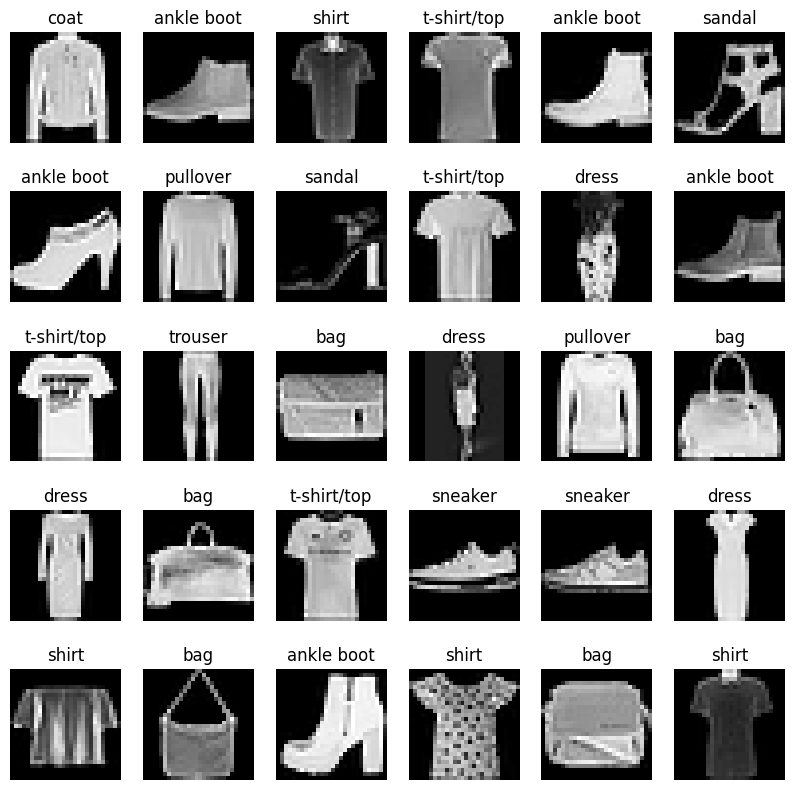

In [230]:
transform=transforms.Compose([transforms.ToTensor(),])
train_data=datasets.FashionMNIST(root='data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST(root='data',train=False,download=True,transform=transform)

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure=mp.figure(figsize=(10,10))
cols,rows=6,5
for i in range(1,cols*rows+1):
    sample=torch.randint(len(train_data),size=(1,)).item()
    img,label=train_data[sample]
    figure.add_subplot(rows,cols,i)
    mp.title(labels_map[label])
    mp.axis('off')
    mp.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
    mp.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')

mp.show()



In [231]:
batch=16
num_work=8
train_loader=DataLoader(train_data,batch_size=batch,shuffle=True,num_workers=num_work)
test_loader=DataLoader(test_data,batch_size=batch,shuffle=True,num_workers=num_work)

img,label=next(iter(train_loader))
img.size()
#label.size()



torch.Size([16, 1, 28, 28])

In [232]:
device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
model=CNNdeff().to(device)
model=model.to(device)
criter=nn.CrossEntropyLoss().to(device)
opt=optim.SGD(model.parameters(),lr=0.001)



In [235]:
num_epochs = 1000
for epoch in range(num_epochs):
    avg_cost = 0
    total_batch = len(train_loader)
    model.train()
    for x, y in train_loader:
        x = x.to(device)  # 데이터를 GPU로 이동
        y = y.to(device)  # 레이블을 GPU로 이동
        output = model(x)
        loss = criter(output, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        avg_cost += loss / total_batch
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

1conv : torch.Size([16, 64, 31, 31])
torch.Size([16, 64, 15, 15])
2lay : torch.Size([16, 256, 18, 18])
torch.Size([16, 256, 9, 9])
torch.Size([16, 20736])
lc1 : torch.Size([16, 16])
lc2 : torch.Size([16, 10])


Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib64/libcudnn_cnn_train.so.8: undefined symbol: _ZN5cudnn3cnn34layerNormFwd_execute_internal_implERKNS_7backend11VariantPackEP11CUstream_stRNS0_18LayerNormFwdParamsERKNS1_20NormForwardOperationEmb, version libcudnn_cnn_infer.so.8
Could not load library libcudnn_cnn_train.so.8. Error: /usr/local/cuda-11.8/lib

RuntimeError: GET was unable to find an engine to execute this computation

In [151]:
sample_image = torch.randn(64, 1, 2, 2)  # [batch_size, channels, height, width]

noise=0.01
model=CNNdeff().to(device)

def diffusion(data,noise):
    noise_data=data+torch.randn_like(data)*noise
    remode_noise=noise_data-torch.randn_like(noise_data)*noise
    return remode_noise

diffusion=diffusion(model(sample_image),noise)

print('=========='*10)

print(model(sample_image))
print('=========='*10)

print(diffusion)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor